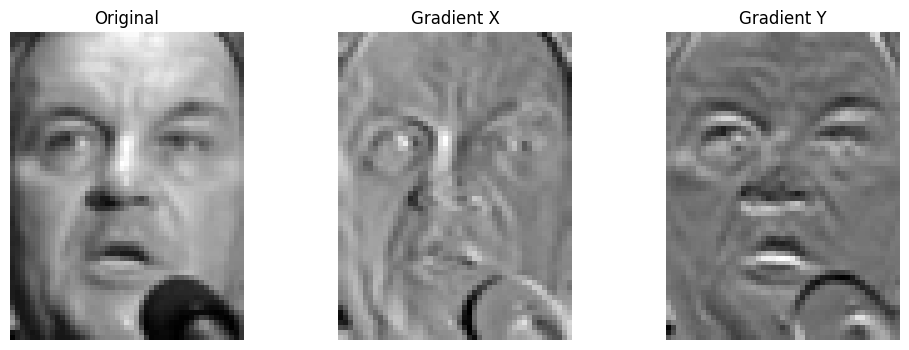

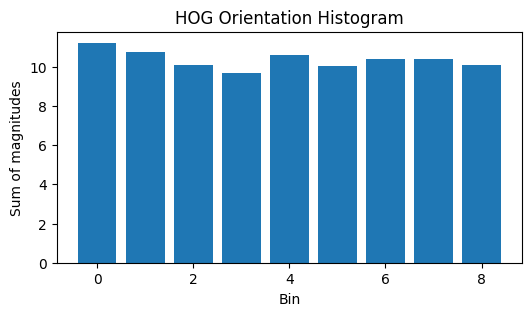

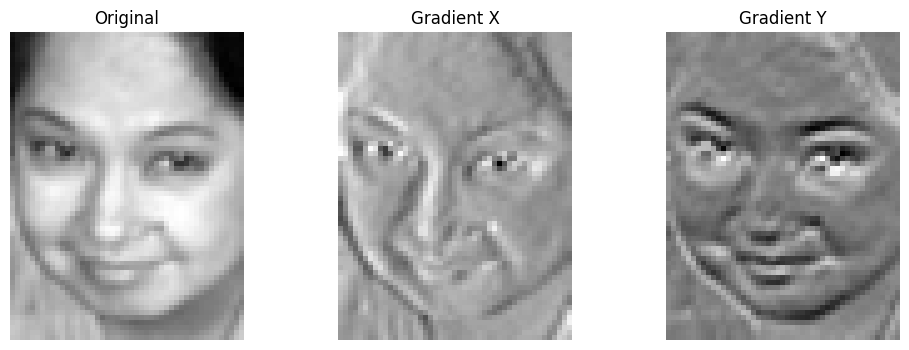

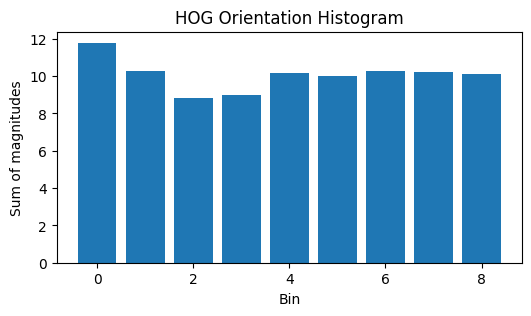

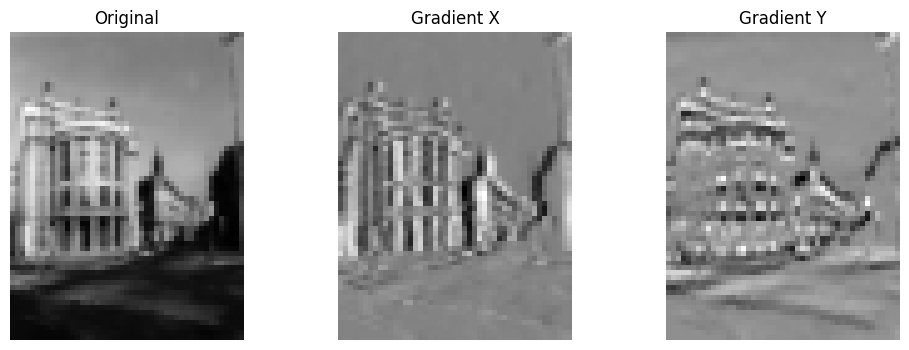

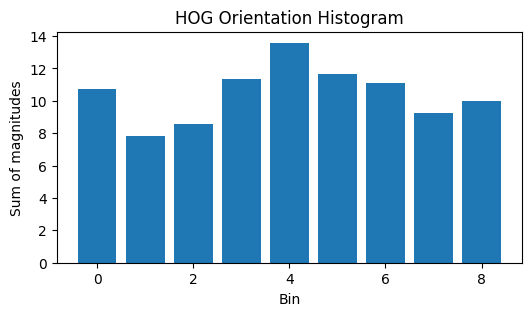

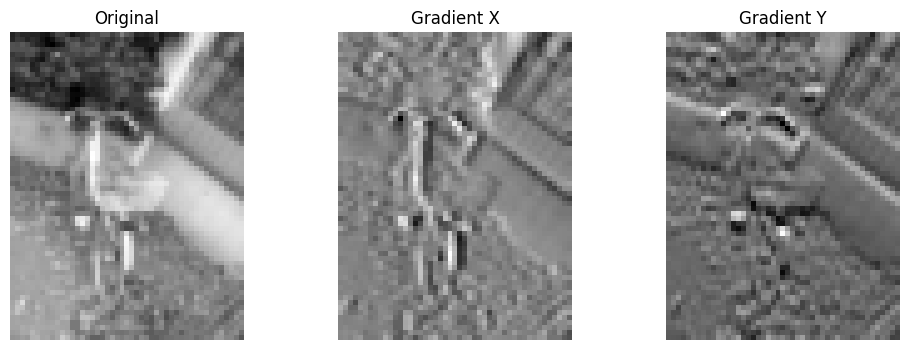

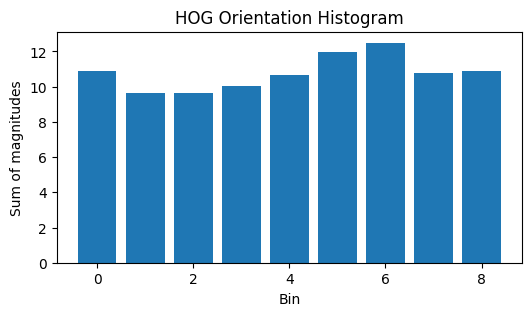


=== SVM best_params={'C': 10} AUC=0.894 ===
              precision    recall  f1-score   support

         0.0      0.864     0.779     0.819       244
         1.0      0.799     0.877     0.836       244

    accuracy                          0.828       488
   macro avg      0.831     0.828     0.827       488
weighted avg      0.831     0.828     0.827       488


=== RF best_params={'max_depth': None, 'n_estimators': 50} AUC=0.915 ===
              precision    recall  f1-score   support

         0.0      0.868     0.807     0.837       244
         1.0      0.820     0.877     0.848       244

    accuracy                          0.842       488
   macro avg      0.844     0.842     0.842       488
weighted avg      0.844     0.842     0.842       488


=== GB best_params={'learning_rate': 0.1, 'n_estimators': 50} AUC=0.914 ===
              precision    recall  f1-score   support

         0.0      0.870     0.766     0.815       244
         1.0      0.791     0.885     0.8

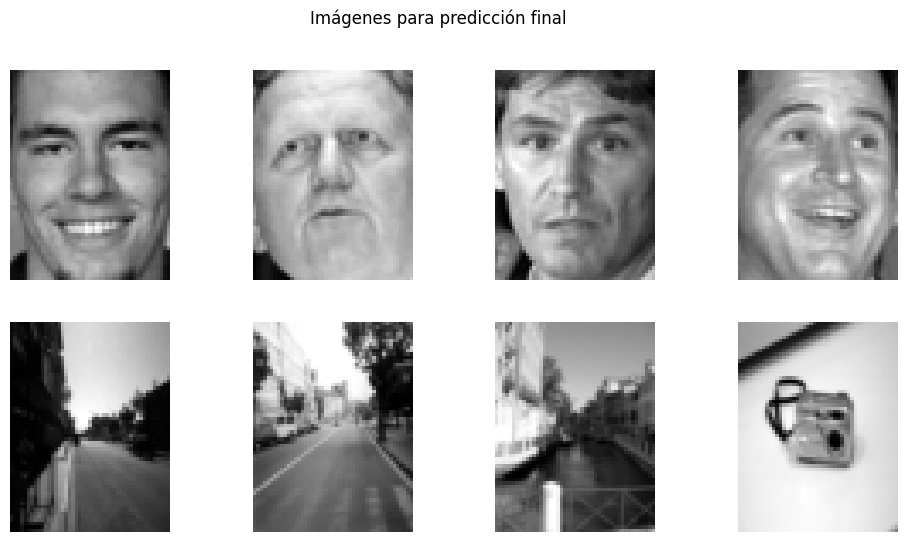

SVM predictions: [1. 1. 0. 1. 0. 0. 0. 1.]
RF predictions: [1. 1. 1. 1. 0. 0. 0. 0.]
GB predictions: [1. 1. 1. 1. 0. 0. 0. 0.]


In [ ]:
# Imports y configuración
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage import transform
from skimage.feature import hog
from sklearn.datasets import fetch_lfw_people
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
from joblib import Parallel, delayed

np.random.seed(0)
DATA_DIR = 'DataSet'

# 1. Carga y muestreo balanceado
lfw = fetch_lfw_people(color=False, resize=0.5)
X_pos, y_pos = lfw.images, np.ones(len(lfw.images), dtype=int)
h, w = X_pos.shape[1:]
neg_dir = os.path.join(DATA_DIR, 'Train','neg')
X_neg = []
for fname in os.listdir(neg_dir):
    img = imread(os.path.join(neg_dir, fname))
    if img.ndim == 3: img = rgb2gray(img)
    X_neg.append(transform.resize(img, (h, w), anti_aliasing=True))
X_neg, y_neg = np.array(X_neg), np.zeros(len(X_neg), dtype=int)

n_samples = min(len(X_pos), len(X_neg))
idx_pos = np.random.choice(len(X_pos), n_samples, replace=False)
idx_neg = np.random.choice(len(X_neg), n_samples, replace=False)
X_bal = np.vstack((X_pos[idx_pos], X_neg[idx_neg]))
y_bal = np.hstack((np.ones(n_samples), np.zeros(n_samples)))
perm = np.random.permutation(len(y_bal))
X, y = X_bal[perm], y_bal[perm]

# 2. Selección aleatoria inicial y visualización de gradientes + HOG
orientations, ppc, cpb, bn = 9, (8,8), (1,1), 'L2-Hys'
def hog_desc(img):
    d = hog(img,
            orientations=orientations,
            pixels_per_cell=ppc,
            cells_per_block=cpb,
            block_norm=bn,
            feature_vector=False)
    return d.reshape(-1, orientations)

pos_inds = np.where(y == 1)[0]
neg_inds = np.where(y == 0)[0]
init_pos = np.random.choice(pos_inds, 2, replace=False)
init_neg = np.random.choice(neg_inds, 2, replace=False)
init_inds = np.hstack((init_pos, init_neg))

for idx in init_inds:
    img = X[idx]
    gy, gx = np.gradient(img)
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(img, cmap='gray');   axes[0].set_title('Original');   axes[0].axis('off')
    axes[1].imshow(gx, cmap='gray');    axes[1].set_title('Gradient X'); axes[1].axis('off')
    axes[2].imshow(gy, cmap='gray');    axes[2].set_title('Gradient Y'); axes[2].axis('off')
    plt.show()
    descs = hog_desc(img)
    hist = descs.sum(axis=0)
    plt.figure(figsize=(6, 3))
    plt.bar(np.arange(len(hist)), hist, color='C0')
    plt.title('HOG Orientation Histogram')
    plt.xlabel('Bin'); plt.ylabel('Sum of magnitudes')
    plt.show()

# 3. Extracción HOG para todo el dataset (paralelizado)
all_desc = Parallel(n_jobs=-1)(
    delayed(hog_desc)(im) for im in X
)

# 4. BoVW con MiniBatchKMeans
stacked = np.vstack(all_desc)
idx_sample = np.random.choice(stacked.shape[0], size=5000, replace=False)
sampled = stacked[idx_sample]
K = 30
mbk = MiniBatchKMeans(n_clusters=K, batch_size=1000, max_iter=100, random_state=0)
mbk.fit(sampled)
codebook = mbk.cluster_centers_

def bovw_hist(descs):
    dists = np.linalg.norm(descs[:, None, :] - codebook[None, :, :], axis=2)
    assigns = np.argmin(dists, axis=1)
    hist, _ = np.histogram(assigns, bins=np.arange(K+1))
    return hist / hist.sum()

X_bovw = np.array([bovw_hist(d) for d in all_desc])

# 5. Split y entrenamiento de modelos
X_tr, X_te, y_tr, y_te, img_tr, img_te = train_test_split(
    X_bovw, y, X,
    test_size=0.2,
    stratify=y,
    random_state=0
)

models = {
    'SVM': GridSearchCV(LinearSVC(max_iter=5000),
                        {'C': [1, 10]}, cv=3, n_jobs=-1),
    'RF' : GridSearchCV(RandomForestClassifier(n_jobs=-1, random_state=0),
                        {'n_estimators': [50,100,150], 'max_depth': [10, None]},
                        cv=3, n_jobs=-1),
    'GB' : GridSearchCV(GradientBoostingClassifier(random_state=0),
                        {'n_estimators': [50,100,150], 'learning_rate': [0.1]},
                        cv=3, n_jobs=-1)
}

for name, gs in models.items():
    gs.fit(X_tr, y_tr)
    preds = gs.predict(X_te)
    if hasattr(gs, 'predict_proba'):
        scores = gs.predict_proba(X_te)[:, 1]
    else:
        scores = gs.decision_function(X_te)
    auc = roc_auc_score(y_te, scores)
    print(f"\n=== {name} best_params={gs.best_params_} AUC={auc:.3f} ===")
    print(classification_report(y_te, preds, digits=3))

# 6. Predicción final para 4 caras y 4 no‑caras al azar
pos_te = np.where(y_te == 1)[0]
neg_te = np.where(y_te == 0)[0]
sample_pos = np.random.choice(pos_te, 4, replace=False)
sample_neg = np.random.choice(neg_te, 4, replace=False)
sample_idx = np.hstack((sample_pos, sample_neg))

# mostrar imágenes
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for ax, im in zip(axes.ravel(), img_te[sample_idx]):
    ax.imshow(im, cmap='gray'); ax.axis('off')
plt.suptitle('Imágenes para predicción final'); plt.show()

# mostrar predicciones de cada modelo
for name, gs in models.items():
    preds = gs.predict(X_te[sample_idx])
    print(f"{name} predictions:", preds)


In [8]:
import joblib

# Supongamos que tu modelo RF ya está entrenado en la variable `rf`
# y tu codebook en la variable `codebook`

# Guardar modelo
joblib.dump(models['RF'].best_estimator_, 'rf_model.pkl')

# Guardar codebook
joblib.dump(codebook, 'codebook.pkl')

# Para cargar más tarde:
# rf_loaded      = joblib.load('rf_model.pkl')
# codebook_loaded = joblib.load('codebook.pkl')


['codebook.pkl']